## *Analytics on Trace Data*

In this notebook we're tying to understand the Trace data, such as basic statistics and stuff. The aim of this notebook end the end is to collapse the equal-cost multipaths or something sround that to reduce the complexity of the data.
There is no real clear direction, but we're trying to answer the questions as we move in the directions, we want to.


In [6]:
# This Extension Reloads the Modules verytime we run this cell
%load_ext autoreload
%autoreload 2

from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from time import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt

import Utility_Modules.r_utils as ut
import Utility_Modules.elasticqueries as qrs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### *Conecting to ElasticSearch*
This connection object work throughout the notebook to retreive data from the ElasticSearch Kibana Instance

Prints **True** if the connection is successful, false otherwise

In [7]:
user = 'sushant'
passwd = 'Mross@fmaB'
credentials = (user, passwd)
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=90, http_auth=credentials)
es.ping()

True

------
**Distinct Counts**

In [8]:
countOf = ['dest_site', 'dest', 'src_site', 'src', 'hash']
for i in countOf:
    print(i," : ", qrs.getUniqueCount(es,'ps_trace',i))

dest_site  :  129
dest  :  948
src_site  :  121
src  :  556
hash  :  4443155


**Ask Shawn**
1. Why is the number of ip's per site more than 1 (we see upto 7 here)
2. Why are there 2 or more ips per hostname
3. Why are there more destinations than sources

------
**Distnct Count (of Field Values)**

In [9]:
countOfBy = ['dest_host', 'dest', 'src_host', 'src','src_site', 'dest_site']
for i in countOfBy:
    (i," : ", qrs.getUniqueCountBy(es,'ps_trace',i))

Size : 818
Size : 948
Size : 491
Size : 556
Size : 121
Size : 129


**Ask Shawn**
1. Src vs Dest

-----
**Frequency Distribution of Source and Destination Hosts Below**

In [6]:
src_data = qrs.getUniqueCountBy(es,'ps_trace','src_host')
dest_data = qrs.getUniqueCountBy(es,'ps_trace','dest_host')

Size : 487
Size : 810


In [7]:
n = 65

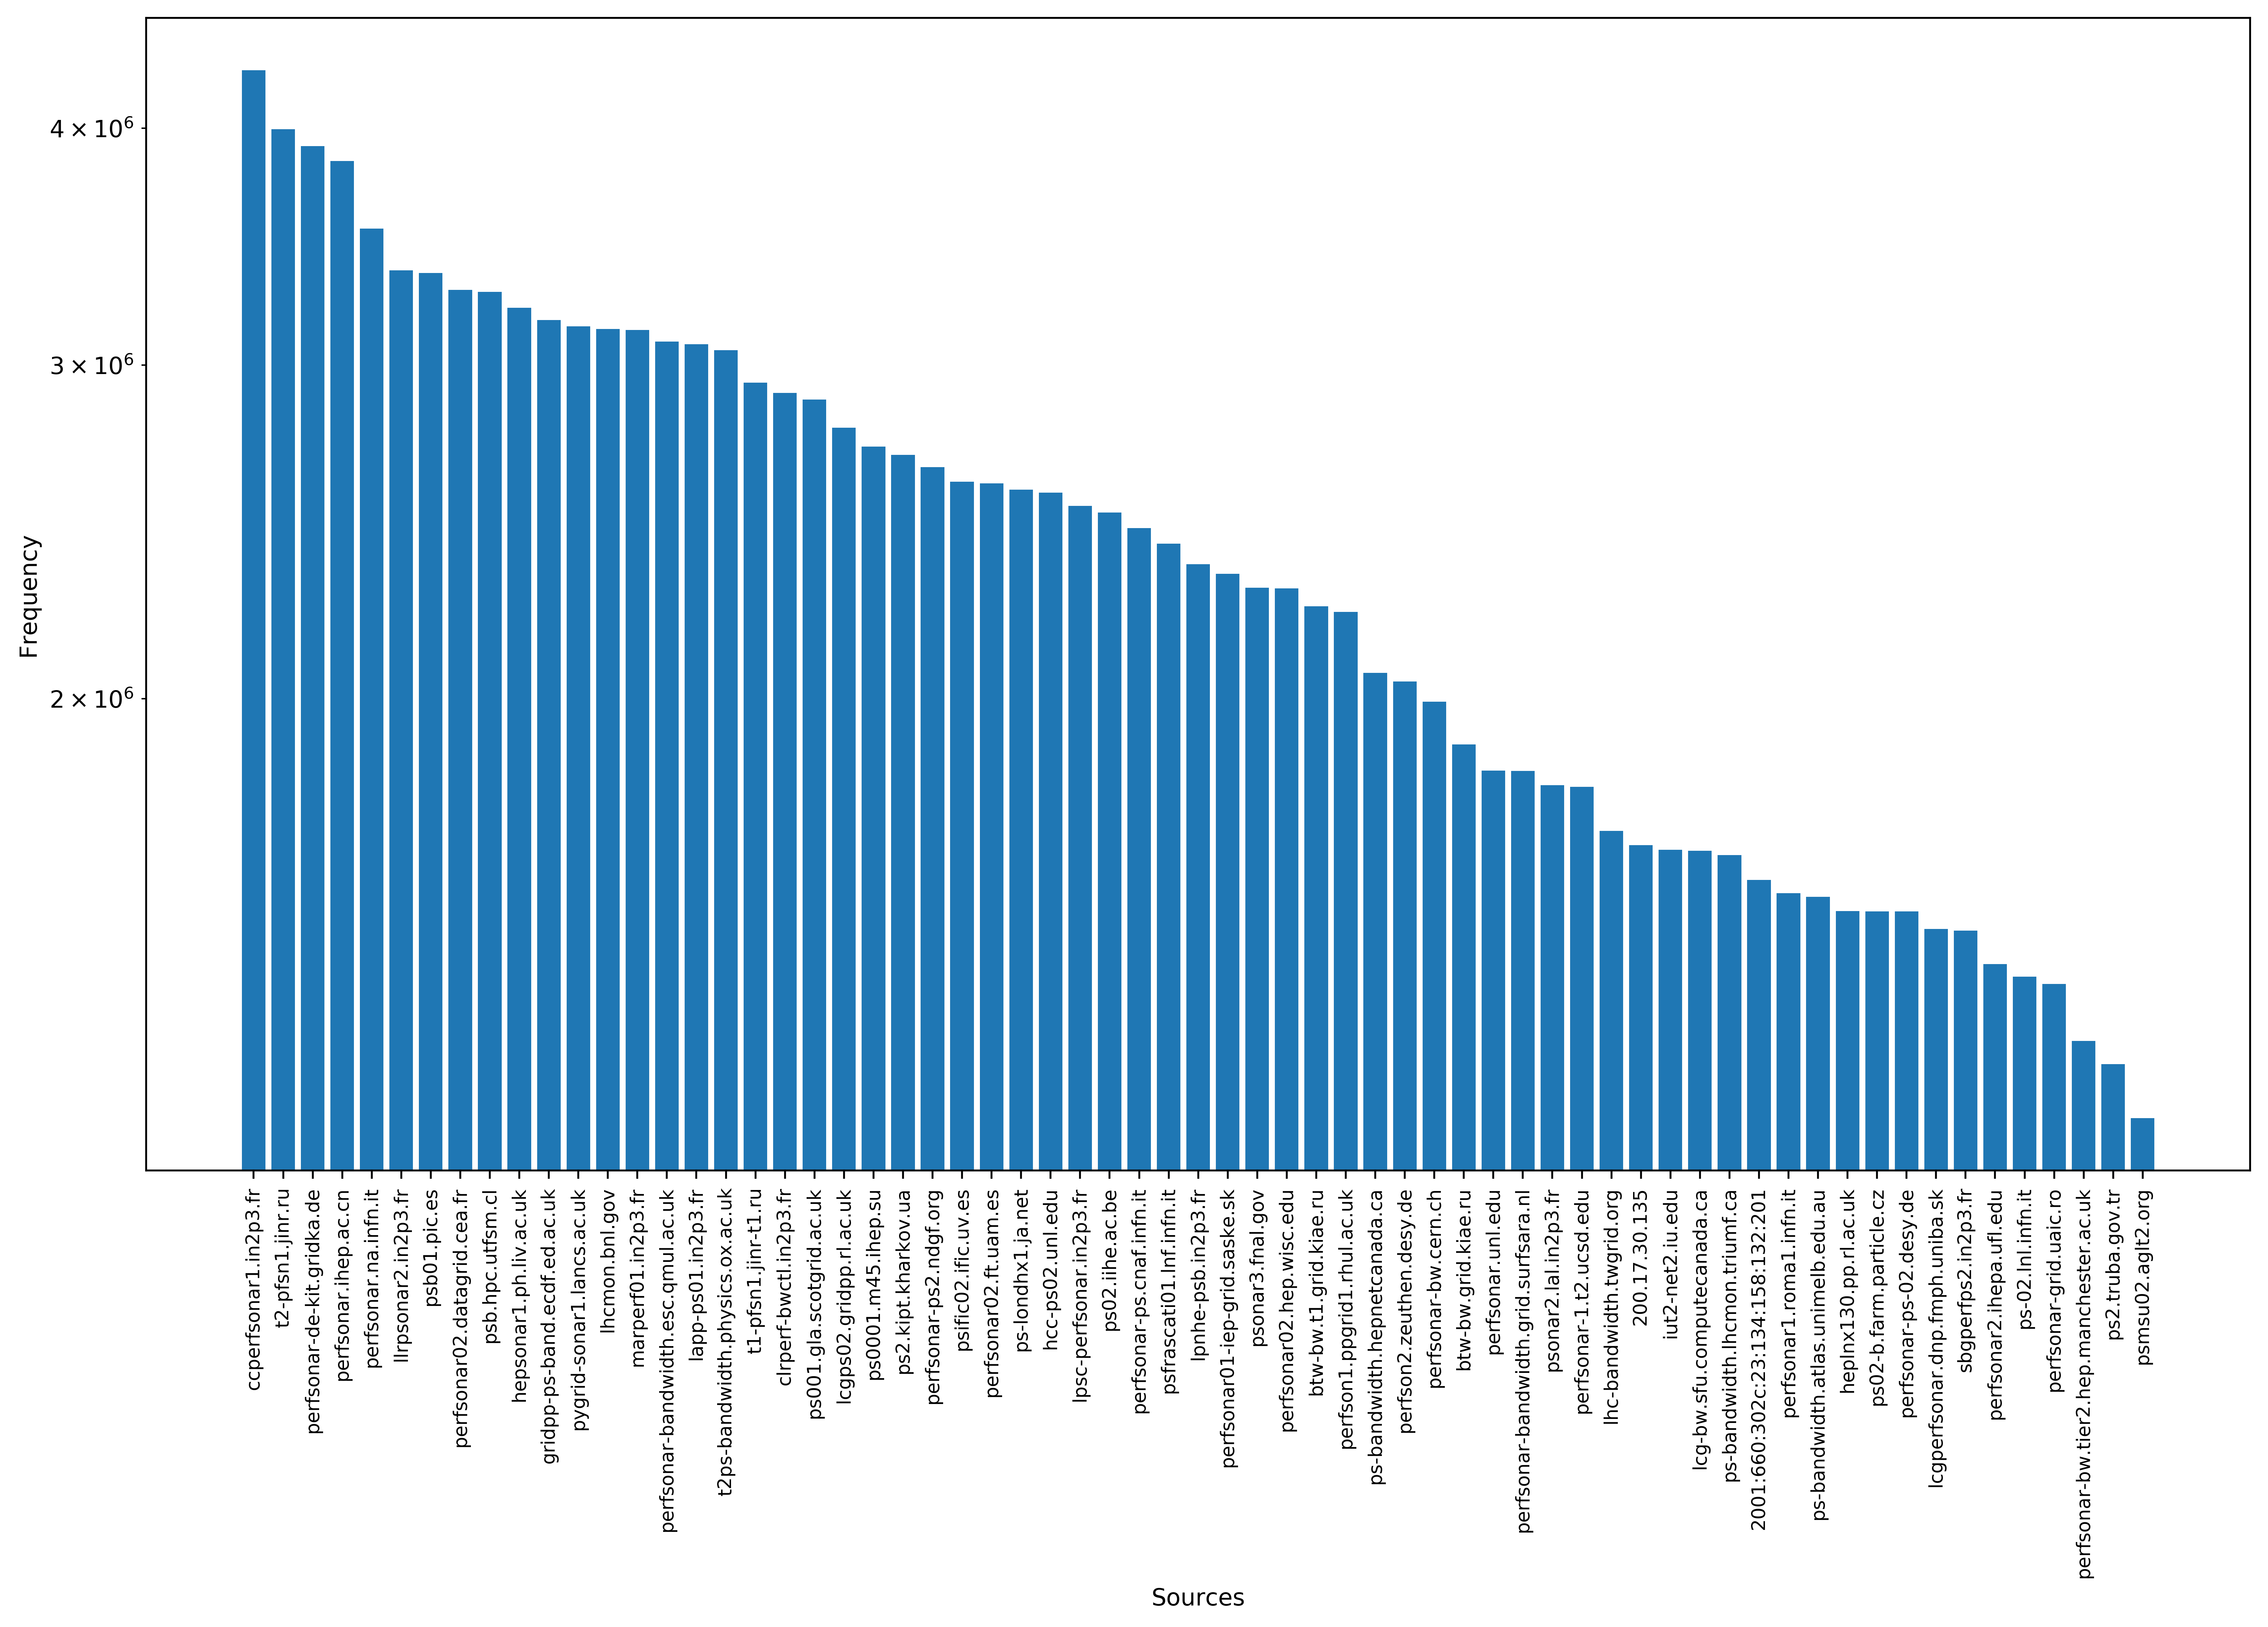

In [8]:
ut.plotByHist(src_data,n,"Sources",plt)

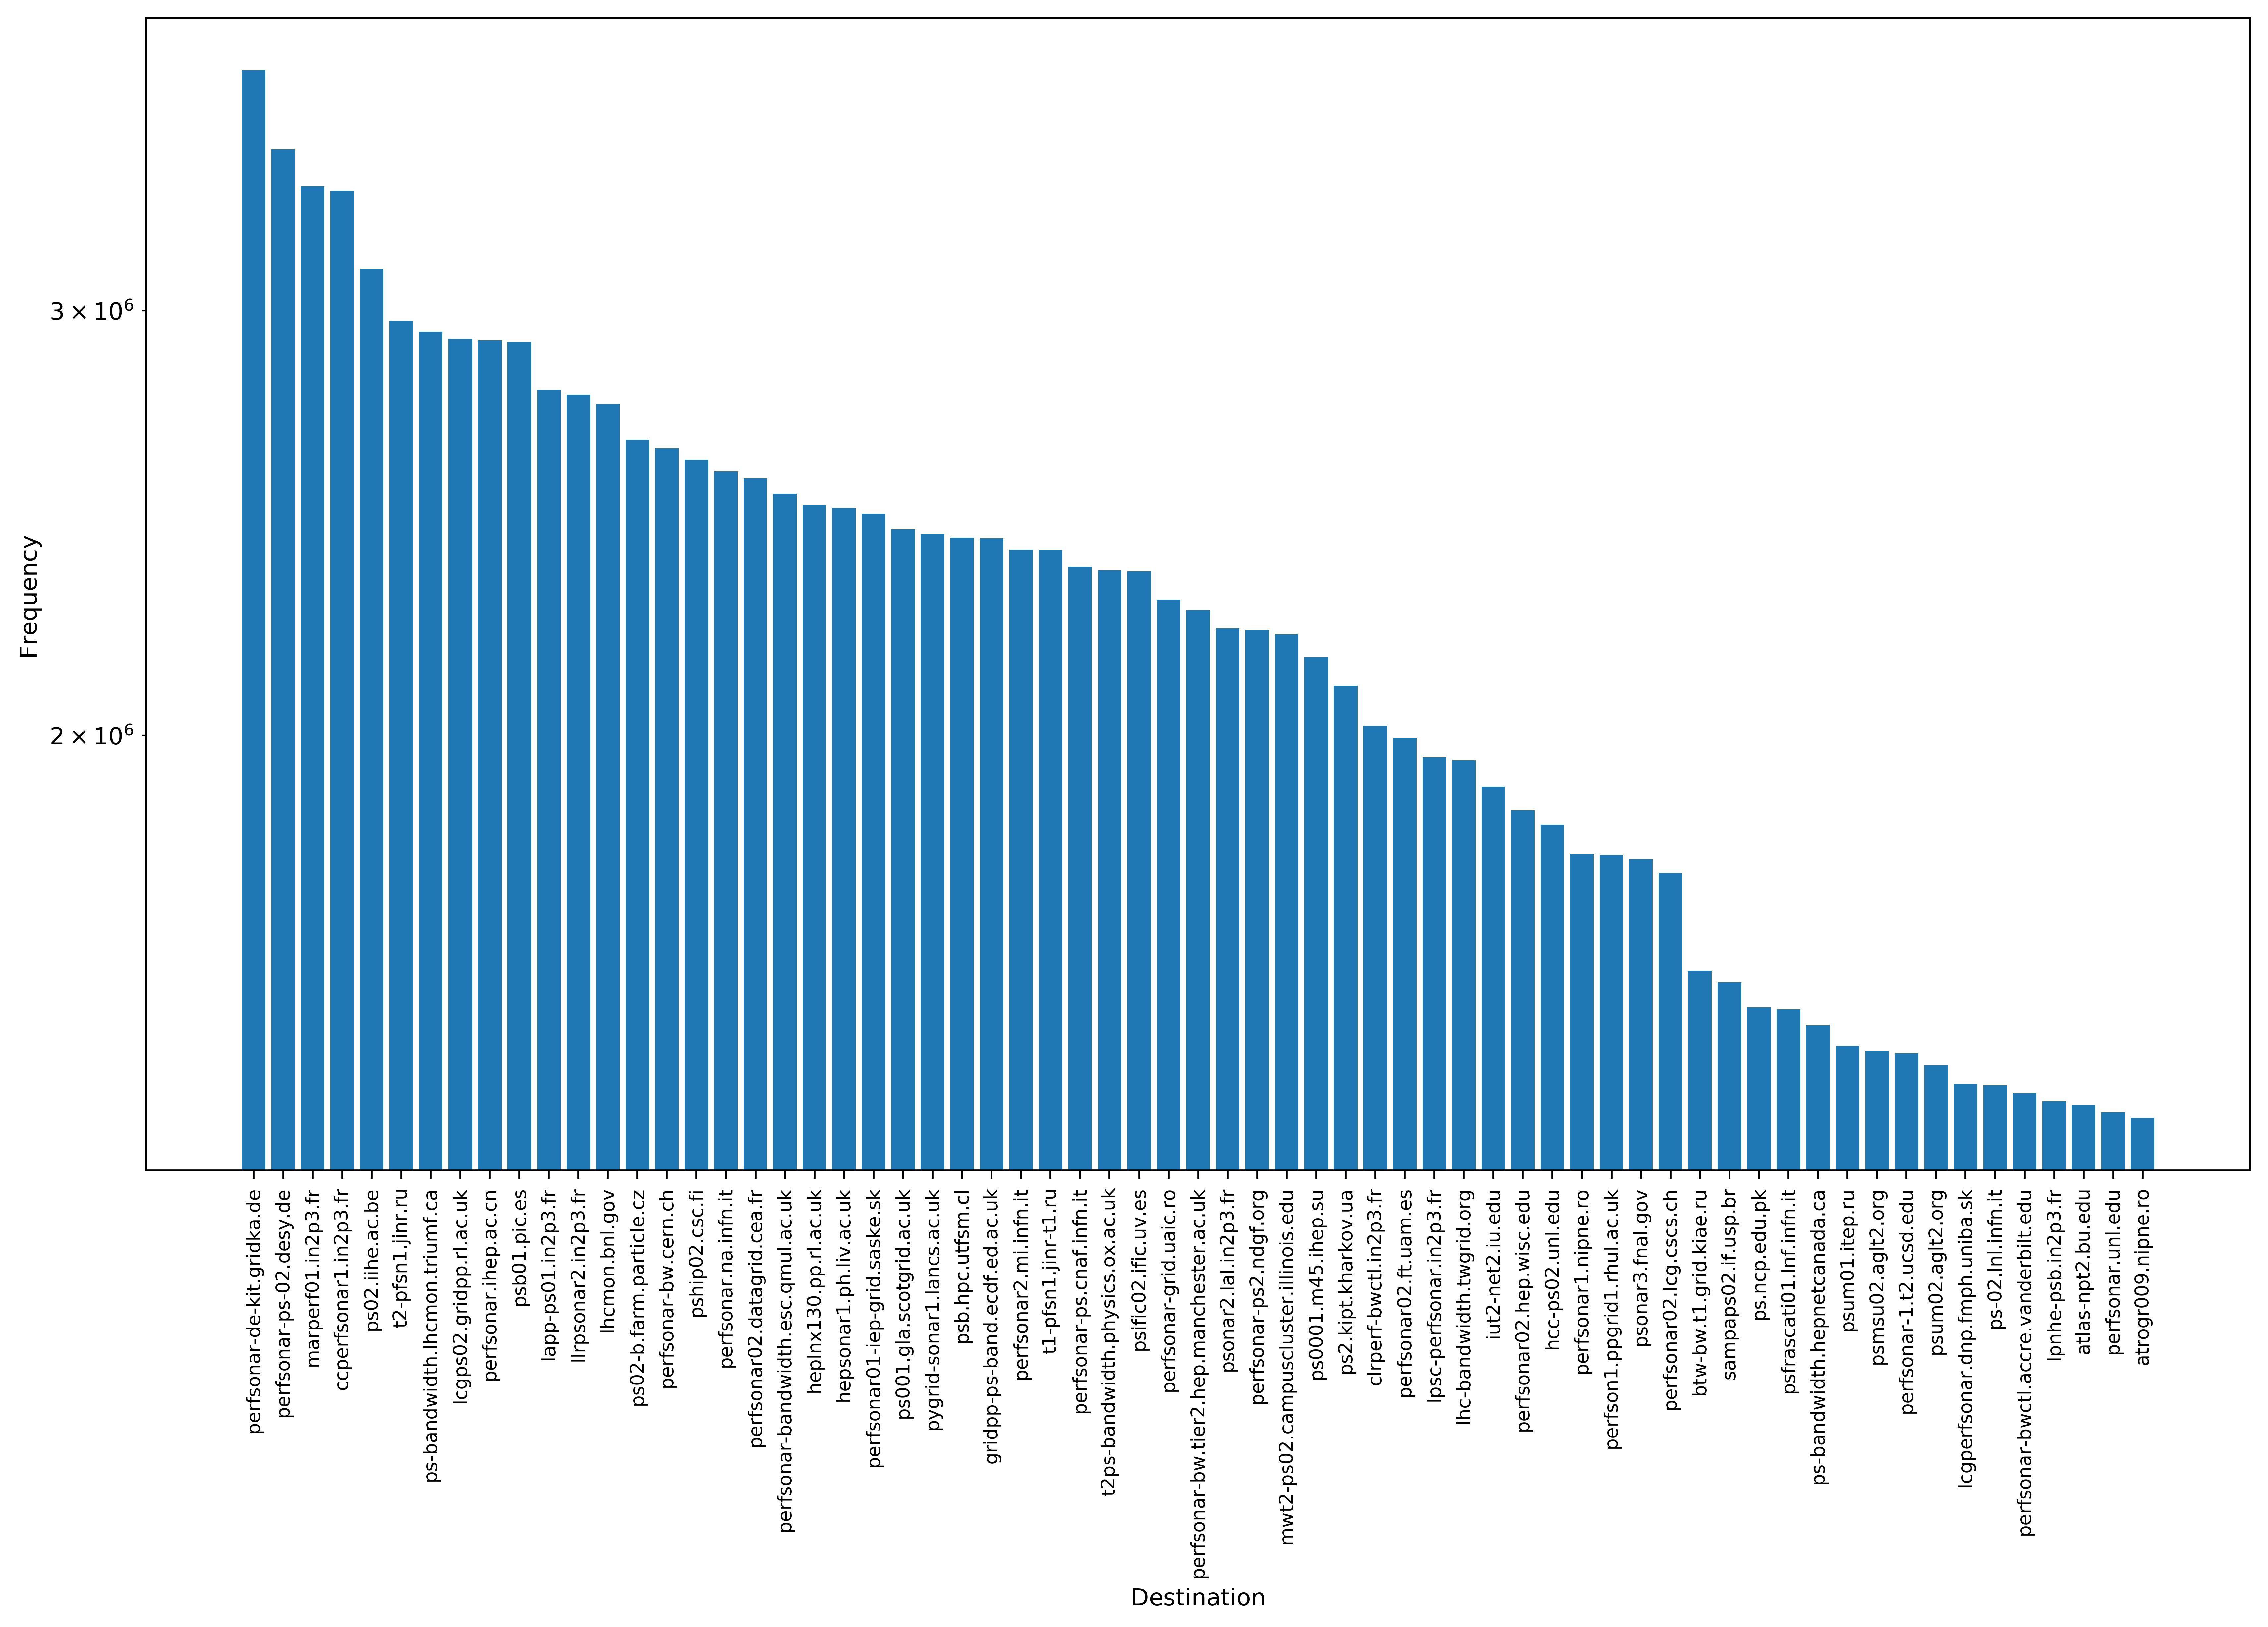

In [9]:
ut.plotByHist(dest_data, n, 'Destination', plt)

-----
**Frequency Distribution of Paths between all pair of nodes (in the past three weeks from today)**

In [3]:
uniqHashPairs = qrs.getNumHashesBetweenHostsInTimeRange(es,'ps_trace',ut.getDateFormat(delta=21),ut.getDateFormat(delta=1))

Number of Source-Destination Pairs:  5901


In [5]:
pair_data = {'Source':[], 'Destination':[], "NumPaths":[]}
for pair in uniqHashPairs['aggregations']['uniq_val']['buckets']: 
    srcdest = pair['key'].split(",")
    pair_data['Source'].append(srcdest[0])
    pair_data['Destination'].append(srcdest[1])
    pair_data['NumPaths'].append(pair['uniq_hash']['value'])

src_dest_df = pd.DataFrame(pair_data)

##### **Mean** and **Standard Deviation** of #Paths between nodes across a 21 day period.  

In [6]:
print('Mean : ', src_dest_df['NumPaths'].mean())
print('Std. Dev : ', np.sqrt(src_dest_df['NumPaths'].var()))

Mean :  33.01052631578948
Std. Dev :  127.88608191906852


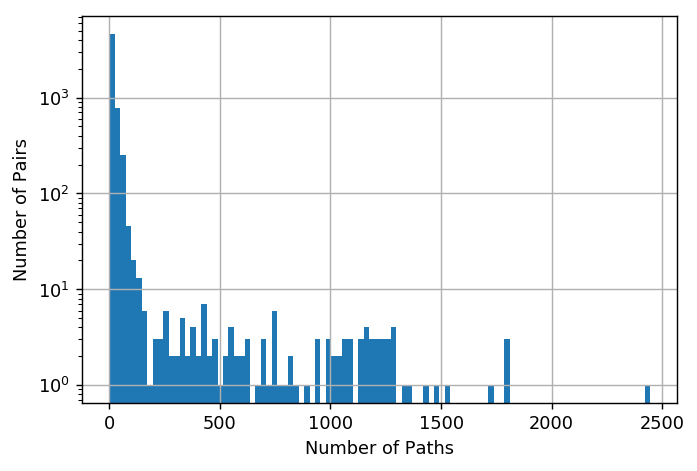

In [7]:
plt.figure(dpi=128)
src_dest_df['NumPaths'].hist(bins=100)
plt.xlabel("Number of Paths")
plt.ylabel("Number of Pairs")
plt.yscale("log")


<Figure size 1536x1024 with 0 Axes>

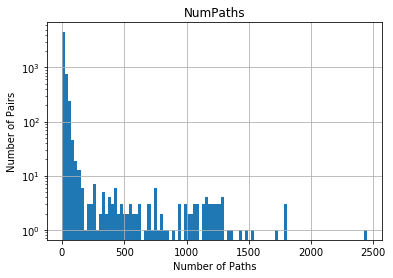

In [9]:
plt.figure(dpi=256)
src_dest_df[src_dest_df['NumPaths'] > 1].hist(bins=100)
plt.xlabel("Number of Paths")
plt.ylabel("Number of Pairs")
plt.yscale("log")

In [22]:
ut.getDateFormat(delta=7)

'1562013135781.979'

hepsonar1.ph.liv.ac.uk perfsonar-bandwidth.grid.pub.ro
ps02-b.farm.particle.cz atlas-npt2.bu.edu
psmsu02.aglt2.org ps001.gla.scotgrid.ac.uk
perfsonar-grid.uaic.ro perfsonar-de-kit.gridka.de
perfsonar-grid.uaic.ro mwt2-ps02.campuscluster.illinois.edu
psb01.pic.es perfsonar2.ihepa.ufl.edu
ps001.gla.scotgrid.ac.uk perfsonar-bandwidth.grid.pub.ro


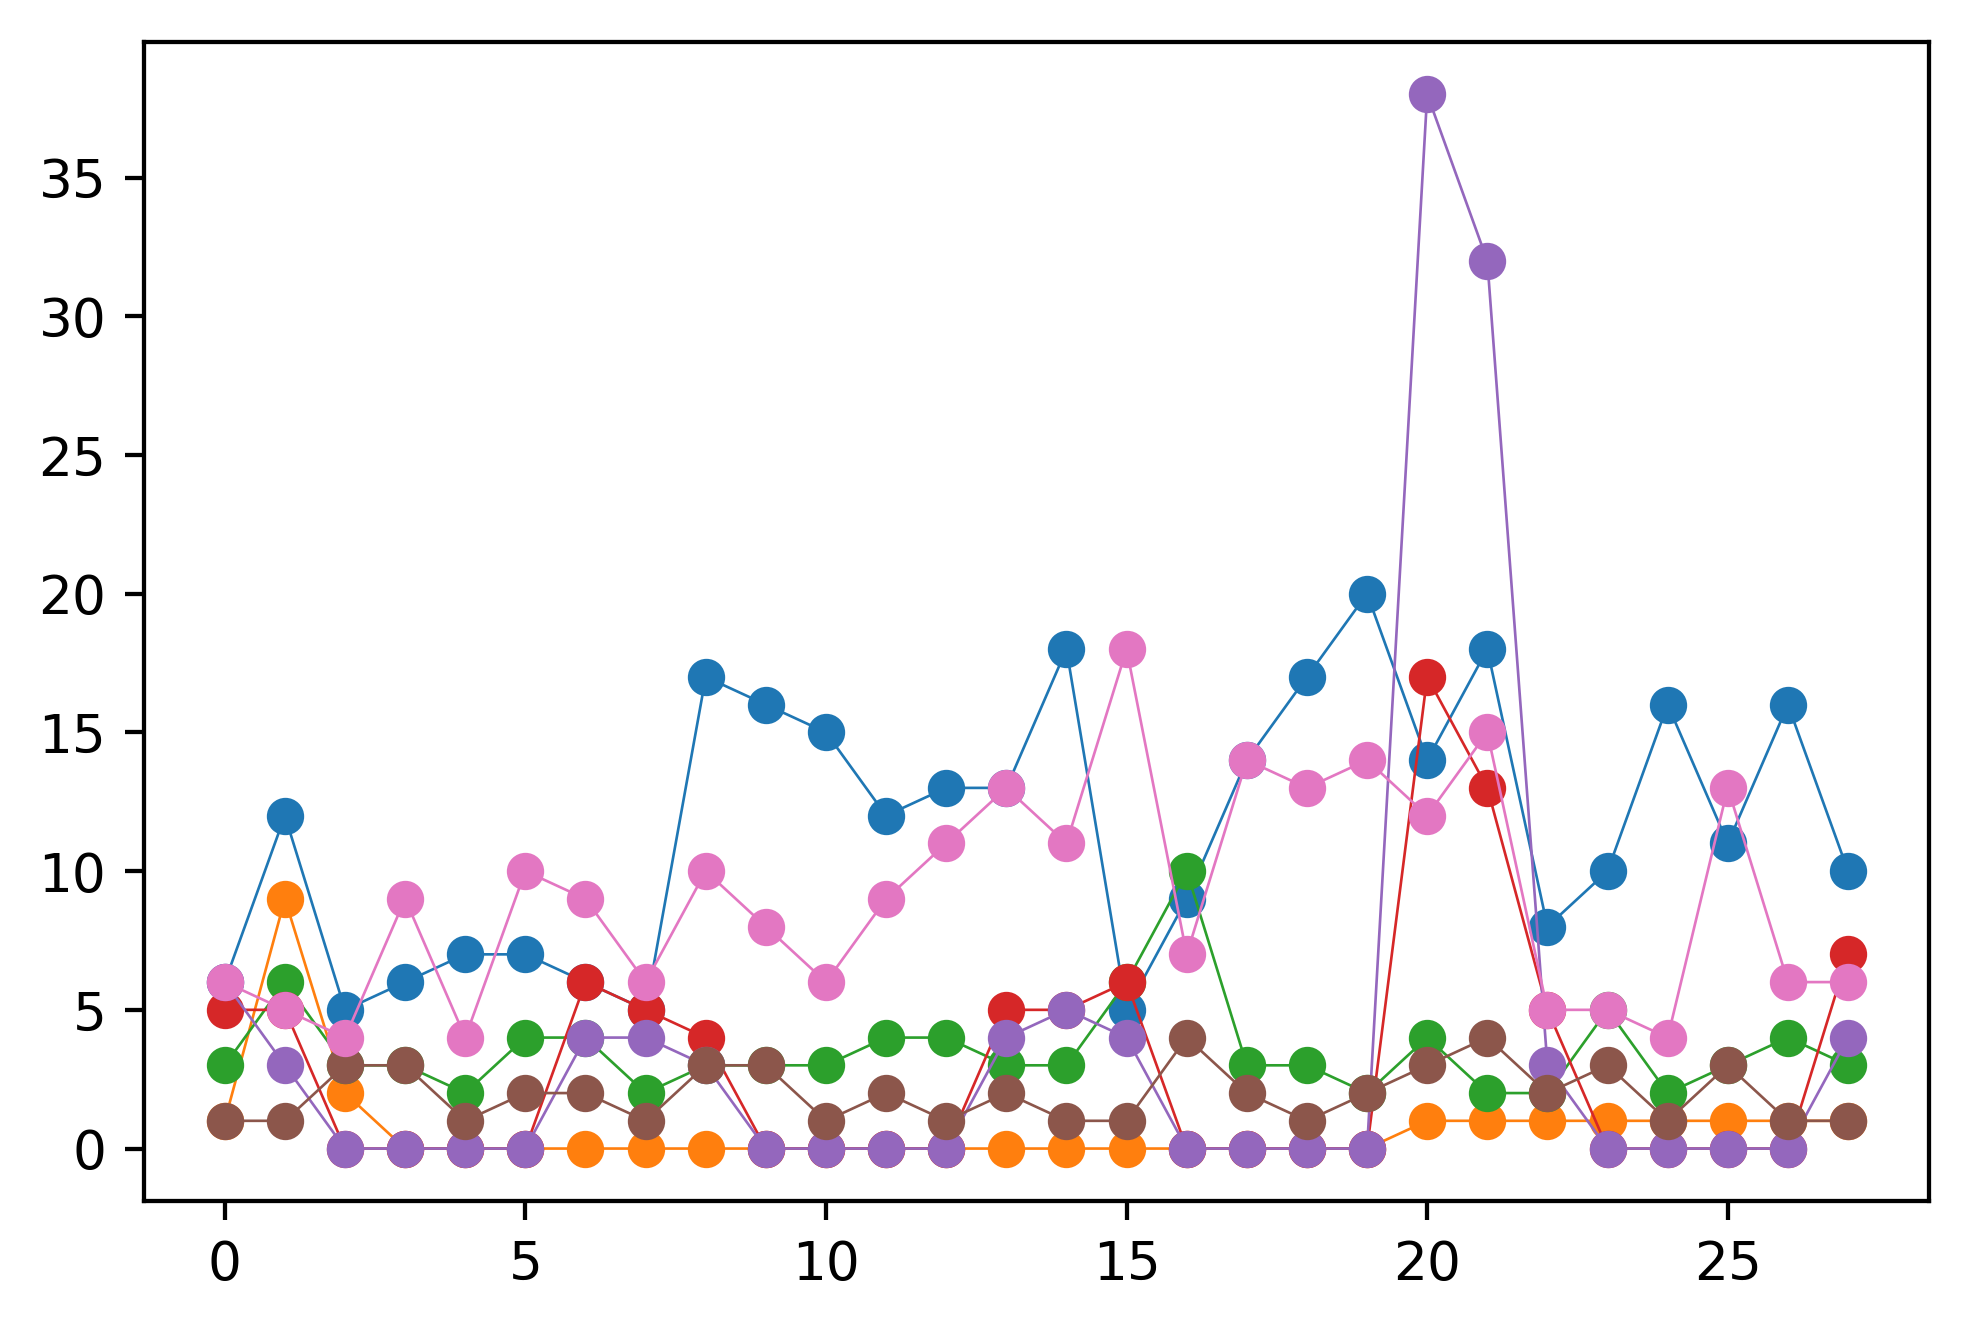

In [15]:
n_samples = 7
smpls = src_dest_df.sample(n=n_samples)
results = [[] for i in range(n_samples)]
j = 0
n_days = 28
plt.figure(dpi=384)
for i,r in smpls.iterrows():
    print(r.Source, r.Destination)
    days = qrs.getDailyUniquePaths(es, 'ps_trace', r.Source, r.Destination,n_days)
    for day in days['aggregations']['time_hist']['buckets']:
        results[j].append(day['uniq_hash']['value'])
    plt.plot(results[j], linewidth=0.5, marker='o',label = r.Source + " > " + r.Destination)
    j += 1

# plt.legend()

`Make global average histograms`

`June 27, 2019`

In [ ]:
def getPaths(es, src, dest, since=1):
    
    toDate = getDateFormat(1)
    fromDate = getDateFormat(since+1)

    query = {
        "_source":{
            "includes":['hops']
        },
        "size":5000,
        "query":{
            "bool": {
              "must": [
                {
                  "range": {
                    "timestamp": {
                      "gte": fromDate,
                      "lte": toDate,
                      "format": "epoch_millis"
                    }
                  }
                },
                {
                  "term": {
                    "src_host": {
                      "value": src
                    }
                  }
                },
                {
                  "term": {
                    "dest_host": {
                      "value": dest
                    }
                  }
                }
              ]
            }
        }
    }
       
    init_res =  es.search(index='ps_trace', body=query, request_timeout=30)  
    results = []
    for res in init_res['hits']['hits']:
        results.append(res['_source']['hops'])
    
    return results

In [ ]:
rsmple = src_dest_df.sample(n=1)
print("Source : ", rsmple.iloc[0,0])
print("Destination : ", rsmple.iloc[0,1])

paths = getPaths(es, rsmple.iloc[0,0], rsmple.iloc[0,1], 7)

host_id = dict()
num_ids = 1
for path in paths:
    for i in range(len(path)):
        try:
            hid = host_id[path[i]]
            path[i] = hid
        except:
            host_id[path[i]] = num_ids
            path[i] = num_ids
            num_ids += 1

plt.figure(dpi=512)
m_size = 2
for path in paths:
    plt.plot(path,'---.',markersize=m_size, marker='o', linewidth=0.6)
#     m_size -= 0.2
# plt.legend()
print("Num Paths: ", len(paths))

**Ask Shawn**

1. Circular Paths

ADD LABELS EVERYWHERE
DOCUMENTATION
MAKE IT READABLE
WAY MORE

FOR ANOMAILES, find max number of different paths, different paths of euqal costs
and how often these nodes appear in different paths.

Get Nodes only 3 hops apart

Total number of unique ips, and hops

Source :  perfsonar-ps2.ndgf.org
Destination :  ps-gsdc02.sdfarm.kr
Num Paths:  974

In [ ]:
datetime(2019,6,1)

### TODO: 
Exclude: Test from everything

Add timerange, past 3 months everywhere.

Add mean, variance and stats in legend